# Introduction

In this notebook, we explore the application of Basisformer, a transformer-based model, for multivariate energy time series forecasting. The dataset used comprises European wholesale electricity prices, with data preprocessing steps including handling missing values, encoding categorical features, and normalizing numerical features. The model is trained and evaluated using this processed data, with the goal of achieving accurate predictions of future energy prices. Detailed performance metrics and visualizations are provided to assess the model's effectiveness and robustness.

Paper link: https://openreview.net/forum?id=xx3qRKvG0T


Repo link: https://github.com/nzl5116190/Basisformer?tab=readme-ov-file

Group Repo Link: https://github.com/basovae/apa_group4_transformers_for_multivar_energy_forecasting/tree/main

# Setup and Data Loading 

This section loads the European wholesale electricity price data from a CSV file, providing an initial examination of its structure. It displays the first few rows and identifies the unique countries in the dataset. Understanding the dataset's structure is crucial for designing an appropriate preprocessing pipeline and feature engineering steps.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
file_path = 'data/all_countries.csv'
data = pd.read_csv(file_path)
data.head()

Country ISO3 Code       Datetime (UTC)     Datetime (Local)  \
0  Austria       AUT  2015-01-01 00:00:00  2015-01-01 01:00:00   
1  Austria       AUT  2015-01-01 01:00:00  2015-01-01 02:00:00   
2  Austria       AUT  2015-01-01 02:00:00  2015-01-01 03:00:00   
3  Austria       AUT  2015-01-01 03:00:00  2015-01-01 04:00:00   
4  Austria       AUT  2015-01-01 04:00:00  2015-01-01 05:00:00   

   Price (EUR/MWhe)  
0             17.93  
1             15.17  
2             16.38  
3             17.38  
4             16.38

In [33]:
data.shape

(2230248, 5)

In [34]:
data.Country.unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Switzerland', 'Czechia',
       'Germany', 'Denmark', 'Spain', 'Estonia', 'Finland', 'France',
       'Greece', 'Croatia', 'Hungary', 'Ireland', 'Italy', 'Lithuania',
       'Luxembourg', 'Latvia', 'North Macedonia', 'Netherlands', 'Norway',
       'Poland', 'Portugal', 'Romania', 'Serbia', 'Slovakia', 'Slovenia',
       'Sweden'], dtype=object)

### Summary

The `summary(df)` function generates a comprehensive summary of the DataFrame, including data types, the number and percentage of missing values, count of non-missing values, and the number of unique values for each column.

In [35]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['missing#'] = df.isna().sum()
    summary_df['missing%'] = round((df.isna().sum() / len(df)) * 100, 2)
    summary_df['count'] = df.count().values
    summary_df['unique'] = df.nunique().values
    return summary_df

summary(data).style.background_gradient(cmap='Purples')

### Plotting Average Prices by Country

The `plot_average_prices(df)` function calculates and visualizes the average energy price for each country using a bar chart. This comparative analysis helps in identifying countries with higher or lower average energy prices, providing insights into regional price variations.


In [36]:
def plot_average_prices(df):
    average_prices = df.groupby('Country')['Price (EUR/MWhe)'].mean()

    average_prices = average_prices.sort_values(ascending=False)

    ## histogram
    plt.figure(figsize=(12, 8))
    average_prices.plot(kind='bar', color='skyblue')
    plt.title('Average Energy Prices by Country')
    plt.xlabel('Country')
    plt.ylabel('Average Price')
    plt.ylim(40, average_prices.max() + 5)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_average_prices(data)

### Generating Country-Specific Summary Statistics

The `country_summary_statistics(df)` function computes detailed summary statistics for each country, such as the total count of price entries, date range, minimum and maximum prices along with their dates, and various quartile values. These statistics are crucial for understanding the distribution and trends of energy prices across different countries. They help in identifying patterns such as seasonal effects, market volatility, and outlier events.

In [37]:
def country_summary_statistics(df):

    def summarize(group):
        min_price = group['Price (EUR/MWhe)'].min()
        max_price = group['Price (EUR/MWhe)'].max()

        min_price_row = group[group['Price (EUR/MWhe)'] == min_price]
        max_price_row = group[group['Price (EUR/MWhe)'] == max_price]

        summary = {
            'count': group['Price (EUR/MWhe)'].count(),
            'start_date': group['Datetime (Local)'].min(),
            'end_date': group['Datetime (Local)'].max(),
            'min_price': min_price,
            'min_price_date': min_price_row['Datetime (Local)'].values[0],
            'max_price': max_price,
            'max_price_date': max_price_row['Datetime (Local)'].values[0],
            '1st_quartile': group['Price (EUR/MWhe)'].quantile(0.25),
            'median': group['Price (EUR/MWhe)'].median(),
            '3rd_quartile': group['Price (EUR/MWhe)'].quantile(0.75),
            'mean': group['Price (EUR/MWhe)'].mean(),
        }
        return pd.Series(summary)

    summary_df = df.groupby('Country').apply(summarize).reset_index()

    return summary_df

data_summary = country_summary_statistics(data)
data_summary

Country  count           start_date             end_date  \
0           Austria  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
1           Belgium  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
2          Bulgaria  66456  2016-10-01 03:00:00  2024-05-01 02:00:00   
3           Croatia  57696  2017-10-01 02:00:00  2024-05-01 01:00:00   
4           Czechia  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
5           Denmark  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
6           Estonia  81792  2015-01-01 02:00:00  2024-05-01 02:00:00   
7           Finland  81792  2015-01-01 02:00:00  2024-05-01 02:00:00   
8            France  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
9           Germany  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
10           Greece  81792  2015-01-01 02:00:00  2024-05-01 02:00:00   
11          Hungary  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
12          Ireland  69312  2015-01-01 00:00:00  2024-05-01 00:00:00   
13            Italy  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
14           Latvia  81792  2015-01-01 02:00:00  2024-05-01 02:00:00   
15        Lithuania  81792  2015-01-01 02:00:00  2024-05-01 02:00:00   
16       Luxembourg  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
17      Netherlands  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
18  North Macedonia   8784  2023-05-01 02:00:00  2024-05-01 01:00:00   
19           Norway  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
20           Poland  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
21         Portugal  81792  2015-01-01 00:00:00  2024-05-01 00:00:00   
22          Romania  81792  2015-01-01 02:00:00  2024-05-01 02:00:00   
23           Serbia  64992  2016-12-01 01:00:00  2024-05-01 01:00:00   
24         Slovakia  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
25         Slovenia  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
26            Spain  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
27           Sweden  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   
28      Switzerland  81792  2015-01-01 01:00:00  2024-05-01 01:00:00   

    min_price       min_price_date  max_price       max_price_date  \
0     -500.00  2023-07-02 14:00:00     908.90  2022-08-29 16:00:00   
1     -500.00  2019-06-08 02:00:00     871.00  2022-08-29 19:00:00   
2      -45.00  2024-04-13 14:00:00    3119.84  2017-02-23 19:00:00   
3     -500.00  2023-07-02 14:00:00     920.00  2022-08-30 20:00:00   
4      -68.54  2023-05-28 13:00:00     871.00  2022-08-29 19:00:00   
5     -288.14  2023-07-02 14:00:00     871.00  2022-08-29 19:00:00   
6      -60.04  2023-07-16 15:00:00    4000.00  2022-08-17 18:00:00   
7     -500.00  2023-11-24 15:00:00    1896.00  2024-01-05 19:00:00   
8     -134.94  2023-07-02 15:00:00    2987.78  2022-04-04 08:00:00   
9     -500.00  2023-07-02 14:00:00    1047.11  2022-08-23 20:00:00   
10      -1.02  2024-04-28 10:00:00     936.33  2022-08-30 20:00:00   
11    -500.00  2023-07-02 14:00:00    1047.10  2022-08-30 19:00:00   
12    -100.00  2016-09-24 06:00:00    1000.00  2017-08-17 18:00:00   
13       0.00  2020-04-05 14:00:00     870.00  2022-08-27 20:00:00   
14     -56.55  2023-07-16 15:00:00    4000.00  2022-08-17 18:00:00   
15     -56.55  2023-07-16 15:00:00    4000.00  2022-08-17 18:00:00   
16    -500.00  2023-07-02 14:00:00    1047.11  2022-08-23 20:00:00   
17    -500.00  2023-07-02 13:00:00     871.00  2022-08-29 19:00:00   
18       0.00  2023-06-05 00:00:00     273.60  2023-09-12 19:00:00   
19     -32.71  2023-07-16 14:00:00     587.63  2022-12-13 17:00:00   
20     -46.24  2024-04-28 12:00:00     771.00  2022-08-23 20:00:00   
21      -0.63  2024-04-15 15:00:00     651.00  2022-03-08 17:00:00   
22     -65.06  2024-04-28 15:00:00     964.21  2022-08-30 20:00:00   
23       0.00  2017-01-22 00:00:00     889.52  2022-08-30 19:00:00   
24     -65.06  2024-04-28 14:00:00     900.23  2022-08-30 20:00:00   
25    -500.00  2023-07-02 14:00

### Boxplot of Energy Prices by Country

Using Seaborn, this section creates boxplots of energy prices for each country, ordered by mean price. Boxplots effectively depict the distribution, central tendency, and variability of prices within each country. They highlight outliers and potential anomalies in the data, providing a visual tool to compare the spread and skewness of energy prices across different regions.


In [38]:
data_summary = data_summary.sort_values(by='mean', ascending=False)

# Plot boxplots using Seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='Country', y='Price (EUR/MWhe)', order=data_summary['Country'])
plt.title("Boxplots of Energy Prices by Country")
plt.xlabel("Country")
plt.ylabel("Energy Price (EUR/MWhe)")
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

# Project Structure

The project structure comprises main script, model files, data_provider modules, and supporting scripts. 

## Basisformer Model

The ⁠ Basisformer ⁠ class represents a transformer-based model designed for multivariate time series forecasting. It includes several components to handle complex dependencies within the data. Key features of this model include:

### Initialization (⁠ _init_ ⁠ method)
The model is initialized with various parameters such as sequence length (⁠ seq_len ⁠), prediction length (⁠ pred_len ⁠), model dimension (⁠ d_model ⁠), number of attention heads (⁠ heads ⁠), number of learnable basis functions (⁠ basis_nums ⁠), number of blocks (⁠ block_nums ⁠), bottleneck size (⁠ bottle ⁠), mapping bottleneck size (⁠ map_bottleneck ⁠), device (⁠ device ⁠), and temperature parameter for contrastive learning (⁠ tau ⁠). The model includes several layers and sub-networks for processing input sequences, projecting features, and handling time-series data with non-stationarity.

### Forward Pass (⁠ forward ⁠ method)
The forward pass normalizes the input data to have zero mean and unit variance. Then using linear transformations, the input features are projected into a higher-dimensional space. The model uses a mapping MLP to transform the time encoding, which is combined with the input features through attention mechanisms. The attention scores are computed using the ⁠ Coefnet ⁠ class, which performs cross-attention operations between the basis functions and the input features. The output is generated by combining the attention scores with the projected basis functions, while applying additional transformations to match the output dimensions.

### Loss Calculation
During training, the model computes different kind of losses to optimize its parameters. These include:

- Prediction Loss (⁠ loss_p ⁠): Measures the mean squared error between the predicted and actual values.
- Entropy Loss (⁠ l_entropy ⁠): A contrasting loss that enables the model to differentiate between different time steps.
- Smoothness Loss (⁠ l_smooth ⁠): Ensures the smoothness of the learned basis functions by penalizing large variations.

The model outputs the predicted values and attention scores, which can be used for further analysis and visualization. The architecture of Basisformer allows it to effectively capture and forecast complex patterns in multivariate time series data, making it suitable for our energy price forecasting.


## Inspection of Preprocessed Data
Within the data_provider module, there are three essential files: data_factory.py, data_loader.py, and timefeatures.py. Within data_factory.py, the data_provider function is responsible for creating datasets and data loaders based on the specified flag for training, validation, or testing purposes. In data_loader.py, the Dataset_Energy class is present, which sets up the dataset, processes the data, and offers functions to access individual data points and the dataset's length. Lastly, timefeatures.py contains the time_features function, which generates time-related features based on the specified frequency.

This section prints the processed data arrays (`data_x` and `data_stamp`) to verify the correctness of the preprocessing steps. This inspection is crucial to ensure that the data is appropriately prepared for model training and evaluation. The `data_stamp` array contains time-based features, which are essential for capturing temporal dependencies in the data.


In [39]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

class Data:
    def __init__(self, root_path, data_path, target, features, seq_len, set_type, timeenc, freq):
        self.root_path = root_path
        self.data_path = data_path
        self.target = target
        self.features = features
        self.scale = True
        self.seq_len = seq_len
        self.set_type = set_type
        self.timeenc = timeenc
        self.freq = freq
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path, self.data_path))

        ## encoding the country column
        country_encoded = pd.get_dummies(df_raw['Country'])
        df_raw = pd.concat([df_raw, country_encoded], axis=1)
        df_raw = df_raw.drop(columns=['ISO3 Code', 'Datetime (Local)', 'Country'])
        print(df_raw.head())
        
        cols = list(df_raw.columns)
        ## printing results
        print("Columns before removal:", cols)
        print("Target column:", self.target)
        
        if self.target in cols:
            cols.remove(self.target)
        else:
            print(f"Warning: target '{self.target}' not found in columns list.")
        
        if 'Datetime (UTC)' in cols:
            cols.remove('Datetime (UTC)')
        else:
            print("Warning: 'Datetime (UTC)' not found in columns list.")
        
        df_raw = df_raw[['Datetime (UTC)'] + cols + [self.target]]
        
        ## printing results
        print("Columns after removal:", list(df_raw.columns))

        num_train = int(len(df_raw) * 0.7)
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['Datetime (UTC)']][border1:border2]
        df_stamp['Datetime (UTC)'] = pd.to_datetime(df_stamp['Datetime (UTC)'])
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp['Datetime (UTC)'].apply(lambda row: row.month)
            df_stamp['day'] = df_stamp['Datetime (UTC)'].apply(lambda row: row.day)
            df_stamp['weekday'] = df_stamp['Datetime (UTC)'].apply(lambda row: row.weekday())
            df_stamp['hour'] = df_stamp['Datetime (UTC)'].apply(lambda row: row.hour)
            data_stamp = df_stamp.drop(['Datetime (UTC)'], axis=1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['Datetime (UTC)'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

## example values to see results
root_path = 'data'
data_path = 'all_countries.csv'
target = 'Price (EUR/MWhe)'
features = 'M'
seq_len = 96
set_type = 0 
timeenc = 0
freq = 'h'

data_instance = Data(root_path, data_path, target, features, seq_len, set_type, timeenc, freq)

## date and time encoding
print("Data Stamp:")
print(data_instance.data_stamp)

        Datetime (UTC)  Price (EUR/MWhe)  Austria  Belgium  Bulgaria  Croatia  \
0  2015-01-01 00:00:00             17.93     True    False     False    False   
1  2015-01-01 01:00:00             15.17     True    False     False    False   
2  2015-01-01 02:00:00             16.38     True    False     False    False   
3  2015-01-01 03:00:00             17.38     True    False     False    False   
4  2015-01-01 04:00:00             16.38     True    False     False    False   

   Czechia  Denmark  Estonia  Finland  ...  Norway  Poland  Portugal  Romania  \
0    False    False    False    False  ...   False   False     False    False   
1    False    False    False    False  ...   False   False     False    False   
2    False    False    False    False  ...   False   False     False    False   
3    False    False    False    False  ...   False   False     False    False   
4    False    False    False    False  ...   False   False     False    False   

   Serbia  Slovakia  Slove

It can be seen that the countries have been successfully encoded, in terms of the column order the table is ready to be fed into the model and the data format has been adapted according to the original specifications.

# Model Implementation
The following training, testing and validation parts of the code were taken from the original paper. The destination and target variables have been adapted, as has the number of epochs (set to 1).

## Validation

The `vali` function evaluates the model's performance on the validation dataset. It computes the loss, visualizes sample outputs using TensorBoard, and returns the average validation loss. This function is essential for monitoring model generalization during training. It helps in understanding how well the model performs on unseen data, thus preventing overfitting. The use of TensorBoard for visualization provides a powerful tool for tracking and comparing model performance metrics across different training runs.


In [40]:
def log_and_print(text):
    logging.info(text)
    print(text)
    return

In [41]:
def vali(vali_data, vali_loader, criterion, epoch, writer, flag='vali'):
    total_loss = []
    model.eval()
    count_error = 0
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark,index) in enumerate(vali_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float()

            f_dim = -1 if args.features == 'MS' else 0
            origin = batch_y[:, :args.seq_len, f_dim:].to(device)
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)
            batch_y_mark = batch_y_mark.float().to(device)
            
            real_batch_x = batch_x
            
            outputs,m,attn_x1,attn_x2,attn_y1,attn_y2 = model(batch_x,index.float().to(device),batch_y,train=False,y_mark=batch_y_mark)
            
            pred = outputs.detach().cpu()
            true = batch_y.detach().cpu()

            loss_raw = criterion(pred, true)
            loss = loss_raw.mean()

            total_loss.append(loss)

            if i == 0:
                fig = plot_seq_feature(outputs, batch_y, real_batch_x, flag)
                writer.add_figure("figure_{}".format(flag), fig, global_step=epoch)
                    
    total_loss = np.average(total_loss)
        
    model.train()
    return total_loss


## Training

The `train` function orchestrates the entire training process, including:
- **Parameter Initialization**: Computes the total number of trainable parameters and initializes the `AdaBelief` optimizer and loss functions. The `AdaBelief` optimizer is chosen for its adaptive learning rate capabilities, which help in stabilizing training.
- **Data Loading**: Utilizes the `data_provider` function to load training, validation, and test datasets. Proper data handling ensures that the model is exposed to diverse data patterns during training.
- **Training Loop**: Iterates over multiple epochs, performing forward and backward passes, computing loss, updating model parameters, and logging key metrics. The loss function includes components for prediction error, smoothness regularization, and contrastive loss, balancing the trade-offs between accurate predictions and model robustness.
- **Logging and Saving**: Records training progress and saves model checkpoints to ensure the best model version is preserved. Early stopping is implemented based on validation loss to prevent overfitting.

In [42]:
def train():
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    log_and_print('[Info] Number of parameters: {}'.format(num_params))
    train_set, train_loader = data_provider(args, "train")
    vali_data, vali_loader = data_provider(args,flag='val')
    test_data, test_loader = data_provider(args,flag='test')
    
    para1 = [param for name,param in model.named_parameters() if 'map_MLP' in name]
    para2 = [param for name,param in model.named_parameters() if 'map_MLP' not in name]
    # optimizer = AdaBelief(model.parameters(), lr=args.learning_rate, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False) 
    optimizer = AdaBelief([{'params':para1,'lr':5e-3},{'params':para2,'lr':args.learning_rate}], eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False) 
    # optimizer = AdaBelief(model.parameters(), lr=args.learning_rate, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False) 
    criterion = nn.MSELoss()
    criterion_view = nn.MSELoss(reduction='none')

    train_steps = len(train_loader)

    writer = SummaryWriter(os.path.join(record_dir,'event'))

    best_loss = 0
    count_error = 0
    count = 0
    

    for epoch in range(args.train_epochs):
        train_loss = []
        loss_pred = []
        loss_of_ce = []
        l_s = []
        model.train()
        epoch_time = time.time()
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark,index) in enumerate(train_loader):
            optimizer.zero_grad()

            # to cuda
            batch_x = batch_x.float().to(device) # (B,L,C)
            batch_y = batch_y.float().to(device) # (B,L,C)
            batch_y_mark = batch_y_mark.float().to(device)
            
            f_dim = -1 if args.features == 'MS' else 0
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)

            outputs,loss_infonce,loss_smooth,attn_x1,attn_x2,attn_y1,attn_y2 = model(batch_x,index.float().to(device),batch_y,y_mark=batch_y_mark)
            
            loss_p = criterion(outputs, batch_y)
            lam1 = args.loss_weight_prediction
            lam2 = args.loss_weight_infonce
            lam3 = args.loss_weight_smooth
        
            # if loss_p > 5:
            #     count_error = count_error +1
            #     writer.add_scalar('error_loss', loss_p, global_step=count_error)
            #     fig = plot_seq_feature(outputs, batch_y,batch_x,error=True,input=batch_x)
            #     writer.add_figure("figure_error", fig, global_step=count_error)
            #     log_and_print(loss_p)
                
            loss = lam1 * loss_p + lam2 * loss_infonce  + lam3 * loss_smooth
            train_loss.append(loss.item())
            loss_pred.append(loss_p.item())
            loss_of_ce.append(loss_infonce.item())
            l_s.append(loss_smooth.item())
            loss.backward()
            optimizer.step()


            if (i+1) % (train_steps//5) == 0:
                log_and_print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))


        log_and_print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))

        train_loss = np.average(train_loss)
        loss1 = np.average(loss_pred)
        log_and_print('loss_pred:{0}'.format(loss1))
        loss2 = np.average(loss_of_ce)
        log_and_print('loss entropy:{0}'.format(loss2))
        loss3 = np.average(l_s)
        log_and_print('loss smooth:{0}'.format(loss3))
        vali_loss = vali(vali_data, vali_loader, criterion_view, epoch, writer, 'vali')
        test_loss = vali(test_data, test_loader, criterion_view, epoch, writer, 'test')

        log_and_print("Epoch: {0} | Train Loss: {1:.7f} Vali Loss: {2:.7f} Test Loss: {3:.7f}".format(
            epoch + 1, train_loss, vali_loss, test_loss))

        fig = plot_seq_feature(outputs, batch_y, batch_x)
        writer.add_figure("figure_train", fig, global_step=epoch)
        writer.add_scalar('train_loss', train_loss, global_step=epoch)
        writer.add_scalar('vali_loss', vali_loss, global_step=epoch)
        writer.add_scalar('test_loss', test_loss, global_step=epoch)
        
        ckpt_path = os.path.join(record_dir,args.check_point)
        if not os.path.exists(ckpt_path):
            os.makedirs(ckpt_path)
                
        if best_loss == 0:
            best_loss = vali_loss
            torch.save(model.state_dict(), os.path.join(ckpt_path, 'valid_best_checkpoint.pth'))
        else:
            if vali_loss < best_loss:
                torch.save(model.state_dict(), os.path.join(ckpt_path, 'valid_best_checkpoint.pth'))
                best_loss = vali_loss
                count = 0
            else:
                count = count + 1

        torch.save(model.state_dict(), os.path.join(ckpt_path, 'final_checkpoint.pth'))
        
        if count >= args.patience:
            break
    return


## Testing

The `test` function evaluates the trained model on the test dataset. It loads the best model checkpoint, performs predictions, and computes evaluation metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and Mean Squared Percentage Error (MSPE). These metrics provide a comprehensive assessment of the model's performance on unseen data, indicating its generalization capability.

In [43]:
def test(setting='setting',test=True):
    test_data, test_loader = data_provider(args,flag='test')
    if test:
        log_and_print('loading model')
        model.load_state_dict(torch.load(os.path.join(record_dir,args.check_point, 'valid_best_checkpoint.pth')))
    
    preds = []
    trues = []

    model.eval()
    t1 = time.time()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark,index) in enumerate(test_loader):
            
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)
            
            f_dim = -1 if args.features == 'MS' else 0
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)
            
            outputs,m,attn_x1,attn_x2,attn_y1,attn_y2 = model(batch_x,index.float().to(device),batch_y,train=False,y_mark=batch_y_mark)
                
            outputs = outputs.detach().cpu().numpy()
            batch_y = batch_y.detach().cpu().numpy()

            pred = outputs  
            true = batch_y  

            preds.append(pred)
            trues.append(true)
            
    t2 = time.time()
    log_and_print('total_time:{0}'.format(t2-t1))
    log_and_print('avg_time:{0}'.format((t2-t1)/len(test_data)))

    preds = np.array(preds)
    trues = np.array(trues)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])


    mae, mse, rmse, mape, mspe = metric(preds, trues)
    log_and_print('mse:{}, mae:{}'.format(mse, mae))
    return 


## Initialization of Deep Learning Program

The `init_dl_program` function sets up the deep learning environment, including configuring the device (CPU or GPU), setting random seeds for reproducibility, and configuring parallelism settings for libraries like MKL and cuDNN. Proper initialization is crucial for ensuring consistent and efficient execution of the training and evaluation processes.

In [44]:
def init_dl_program(
    device_name,
    seed=None,
    use_cudnn=True,
    deterministic=False,
    benchmark=False,
    use_tf32=False,
    max_threads=None
):
    import torch
    if max_threads is not None:
            torch.set_num_threads(max_threads)  # intraop
            if torch.get_num_interop_threads() != max_threads:
                torch.set_num_interop_threads(max_threads)  # interop
    try:
        # Import mkl and set the number of threads if available
        import mkl
        mkl.set_num_threads(max_threads)
    except ImportError:
        # If mkl is not available, proceed without it
        pass
        
    if seed is not None:
        random.seed(seed)
        seed += 1
        np.random.seed(seed)
        seed += 1
        torch.manual_seed(seed)
        
    if isinstance(device_name, (str, int)):
        device_name = [device_name]
    
    devices = []
    for t in reversed(device_name):
        t_device = torch.device(t)
        devices.append(t_device)
        if t_device.type == 'cuda':
            assert torch.cuda.is_available()
            torch.cuda.set_device(t_device)
            if seed is not None:
                seed += 1
                torch.cuda.manual_seed(seed)
    devices.reverse()
    torch.backends.cudnn.enabled = use_cudnn
    torch.backends.cudnn.deterministic = deterministic
    torch.backends.cudnn.benchmark = benchmark
    
    if hasattr(torch.backends.cudnn, 'allow_tf32'):
        torch.backends.cudnn.allow_tf32 = use_tf32
        torch.backends.cuda.matmul.allow_tf32 = use_tf32
        
    return devices if len(devices) > 1 else devices[0]
    

## Main Script for Model Training and Testing

This section sets up the argument parser to handle various hyperparameters and configuration settings for the model. It initializes the device and model, and depending on the `is_training` flag, it either trains the model or evaluates it on the test set. This script serves as the entry point for running the training and evaluation processes, managing all necessary configurations and calling the appropriate functions.

In [45]:
#main parser
import argparse

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Time series prediction - Basisformer')
    parser.add_argument('--is_training', type=bool, default=True, help='train or test')
    parser.add_argument('--device', type=int, default=0, help='gpu dvice')

    # data loader
    parser.add_argument('--num_workers', type=int, default=0, help='data loader num workers')
    parser.add_argument('--data', type=str, default='custom', help='dataset type')
    parser.add_argument('--root_path', type=str, default='data', help='root path of the data file')
    parser.add_argument('--data_path', type=str, default='all_countries.csv', help='data file')
    parser.add_argument('--features', type=str, default='M',
                        help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, '
                            'S:univariate predict univariate, MS:multivariate predict univariate')
    parser.add_argument('--target', type=str, default='Price (EUR/MWhe)', help='target feature in S or MS task')
    parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, '
                         'b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')

    # forecasting task
    parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
    parser.add_argument('--label_len', type=int, default=96, help='start token length')
    parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')
    # parser.add_argument('--cross_activation', type=str default='tanh'

    # model define
    parser.add_argument('--embed', type=str, default='timeF',
                        help='time features encoding, options:[timeF, fixed, learned]')
    parser.add_argument('--heads', type=int, default=16, help='head in attention')
    parser.add_argument('--d_model', type=int, default=100, help='dimension of model')
    parser.add_argument('--N', type=int, default=10, help='number of learnable basis')
    parser.add_argument('--block_nums', type=int, default=2, help='number of blocks')
    parser.add_argument('--bottleneck', type=int, default=2, help='reduction of bottleneck')
    parser.add_argument('--map_bottleneck', type=int, default=20, help='reduction of mapping bottleneck')

    # optimization
    parser.add_argument('--train_epochs', type=int, default=1, help='train epochs')
    parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
    parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
    parser.add_argument('--learning_rate', type=float, default=5e-4, help='optimizer learning rate')
    parser.add_argument('--tau', type=float, default=0.07, help='temperature of infonce loss')
    parser.add_argument('--loss_weight_prediction', type=float, default=1.0, help='weight of prediction loss')
    parser.add_argument('--loss_weight_infonce', type=float, default=1.0, help='weight of infonce loss')
    parser.add_argument('--loss_weight_smooth', type=float, default=1.0, help='weight of smooth loss')


    #checkpoint_path
    parser.add_argument('--check_point',type=str,default='checkpoint',help='check point path, relative path')
    
    #args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    
    record_dir = os.path.join('records',args.data_path.split('.')[0],'features_'+args.features,\
                              'seq_len'+str(args.seq_len)+','+'pred_len'+str(args.pred_len))
    if not os.path.exists(record_dir):
        os.makedirs(record_dir)
    
    if args.is_training:
        logger_file = os.path.join(record_dir,'train.log')
    else:
        logger_file = os.path.join(record_dir,'test.log')
        
    if os.path.exists(logger_file):
        with open(logger_file, "w") as file:
            file.truncate(0)
    logging.basicConfig(filename=logger_file, level=logging.INFO)
    
    log_and_print('Args in experiment:')
    log_and_print(args)

    device = init_dl_program(args.device, seed=0,max_threads=8) if torch.cuda.is_available() else "cpu"
    model = Basisformer(args.seq_len,args.pred_len,args.d_model,args.heads,args.N,args.block_nums,args.bottleneck,args.map_bottleneck,device,args.tau)

    log_and_print(model)
    model.to(device)

Args in experiment:
Namespace(N=2, batch_size=2, block_nums=1, bottleneck=2, check_point='checkpoint', d_model=4, data='custom', data_path='all_countries.csv', device=0, embed='timeF', features='M', freq='h', heads=2, is_training=True, label_len=4, learning_rate=0.0005, loss_weight_infonce=1.0, loss_weight_prediction=1.0, loss_weight_smooth=1.0, map_bottleneck=2, num_workers=0, patience=3, pred_len=4, root_path='data', seq_len=4, target='Price (EUR/MWhe)', tau=0.07, train_epochs=1)
Basisformer(
  (coefnet): Coefnet(
    (layers): ModuleList(
      (0): BCAB(
        (cross_attention_basis): channel_AutoCorrelationLayer(
          (query_projection): Linear(in_features=4, out_features=4, bias=True)
          (key_projection): Linear(in_features=4, out_features=4, bias=True)
          (value_projection): Linear(in_features=4, out_features=4, bias=True)
          (out_projection): Linear(in_features=4, out_features=4, bias=True)
          (attend): Softmax(dim=-1)
          (dropout): Dro

/Users/ekaterinabasova/miniconda3/envs/basisformer_x86_env/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Once the model has been defined, it is possible to add a description of what we can adjust to make the process run faster, by defining new specific values for the hyperparameters.

In [ ]:
## defining new parameter values
sys.argv = ['notebook', 
            '--batch_size=16', 
            '--seq_len=24', 
            '--label_len=24', 
            '--pred_len=24', 
            '--train_epochs=1', 
            '--heads=2', 
            '--d_model=4', 
            '--block_nums=1', 
            '--N=5', 
            '--bottleneck=1', 
            '--map_bottleneck=10']
## parsing new values
args = parser.parse_args()


## initializing device and model
device = init_dl_program(args.device, seed=0, max_threads=8) if torch.cuda.is_available() else "cpu"
model = Basisformer(args.seq_len, args.pred_len, args.d_model, args.heads, args.N, args.block_nums, args.bottleneck, args.map_bottleneck, device, args.tau)

## starting
if args.is_training:
    train()
else:
    test()

Unfortunately, due to computing power limitations and the unexpectedly slow performance of the notebook, some training was done locally using bash commands. In the following sections several results are compared.

### Performance Metrics
 The `metric` function computes various evaluation metrics for the predictions. These include Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and Mean Squared Percentage Error (MSPE). These metrics provide a comprehensive assessment of the model's performance, enabling a detailed comparison between different models or training configurations.


In [47]:
# evaluate_tool file
def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))

def CORR(pred, true):
    u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
    d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
    return (u / d).mean(-1)

def MAE(pred, true):
    return np.mean(np.abs(pred - true))

def MSE(pred, true):
    return np.mean((pred - true) ** 2)

def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))

def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)

    return mae, mse, rmse, mape, mspe


Due to a technical error, not all performance metrics are shown in the model log. This will be the next step in improving the existing code.

# Performance and Comparison
### Log Analysis and Visualization

After the program is finished with training, testing and validation and the results are ready, they are saved in the records folder with corresponding log files. This section extracts and visualizes training logs to provide insights into the model's performance over time. By plotting the training loss over iterations, one can assess the convergence behavior of the model. Additionally, final loss values for training, validation, and test datasets are printed to summarize the model's performance.

In [48]:
log_file_path_1 = 'records/all_countries/features_M/seq_len24,pred_len24/train.log'

with open(log_file_path_1, 'r') as file:
    log_contents_1 = file.read()

print(log_contents_1)

INFO:root:Args in experiment:
INFO:root:Namespace(is_training=True, device=0, num_workers=0, data='custom', root_path='data', data_path='all_countries.csv', features='M', target='Price (EUR/MWhe)', freq='h', seq_len=24, label_len=24, pred_len=24, embed='timeF', heads=4, d_model=25, N=5, block_nums=1, bottleneck=1, map_bottleneck=10, train_epochs=1, batch_size=16, patience=3, learning_rate=0.0005, tau=0.07, loss_weight_prediction=1.0, loss_weight_infonce=1.0, loss_weight_smooth=1.0, check_point='checkpoint')
INFO:root:Basisformer(
  (coefnet): Coefnet(
    (layers): ModuleList(
      (0): BCAB(
        (cross_attention_basis): channel_AutoCorrelationLayer(
          (query_projection): Linear(in_features=25, out_features=24, bias=True)
          (key_projection): Linear(in_features=25, out_features=24, bias=True)
          (value_projection): Linear(in_features=25, out_features=24, bias=True)
          (out_projection): Linear(in_features=24, out_features=25, bias=True)
          (atten

The results are visualised below.

Final Train Loss: 0.0066447
Final Validation Loss: 0.0025959
Final Test Loss: 0.0033238


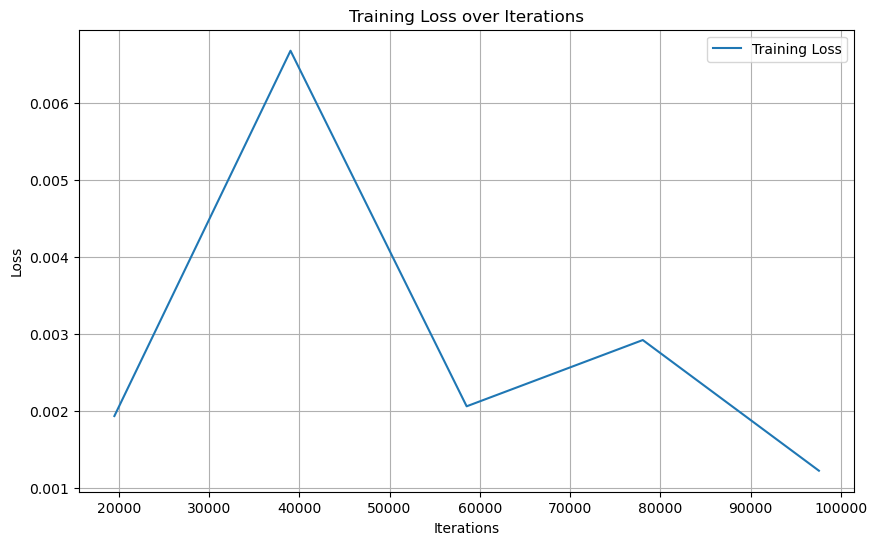

In [63]:
import matplotlib.pyplot as plt
import re

## extracting iteration numbers and losses
iterations = re.findall(r"iters: (\d+)", log_contents_1)
losses = re.findall(r"\| loss: ([0-9.]+)", log_contents_1)

## converting the extracted strings to integers and floats respectively
iterations = [int(iter) for iter in iterations]
losses = [float(loss) for loss in losses]

## exctracting final loss values
train_loss_match = re.search(r"Train Loss: ([0-9.]+)", log_contents_1)
vali_loss_match = re.search(r"Vali Loss: ([0-9.]+)", log_contents_1)
test_loss_match = re.search(r"Test Loss: ([0-9.]+)", log_contents_1)

train_loss = float(train_loss_match.group(1))
vali_loss = float(vali_loss_match.group(1))
test_loss = float(test_loss_match.group(1))

## printing  loss values
print(f"Final Train Loss: {train_loss}")
print(f"Final Validation Loss: {vali_loss}")
print(f"Final Test Loss: {test_loss}")

## plotting over iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.grid(True)
plt.show()

The training loss performance shows an initial decrease followed by a sharp increase around the 40,000th iteration, indicating potential instability. After this peak, the loss significantly declines, although some fluctuations are observed before a steady decrease towards the end. The final low train, validation, and test losses suggest good model performance. To inscrease performance, adjustments such as fine-tuning the learning rate, implementing early stopping, adding regularization, and potentially running additional epochs could be usefull.


## Forecasting Power

This section logs the results from multiple runs with different forecasting horizons. It includes training, validation, and test losses, as well as the time taken for each run. Such comparisons are essential for evaluating the robustness and efficiency of the model under varying conditions. By plotting these metrics, one can visually assess the impact of different forecasting horizons on model performance.

Tests were run on four different forecast regions (Run 1: pred_len 96, Run 2: pred_len 192, Run 3: pred_len 336, Run 3: pred_len720), comparing the model's performance over different forecast lengths. This allowed us to see how the model performed in different situations. The results show where some improvements can be made to get even better results.

This scenario was created using python files and bash commands, so the end results are copied and summarised below.

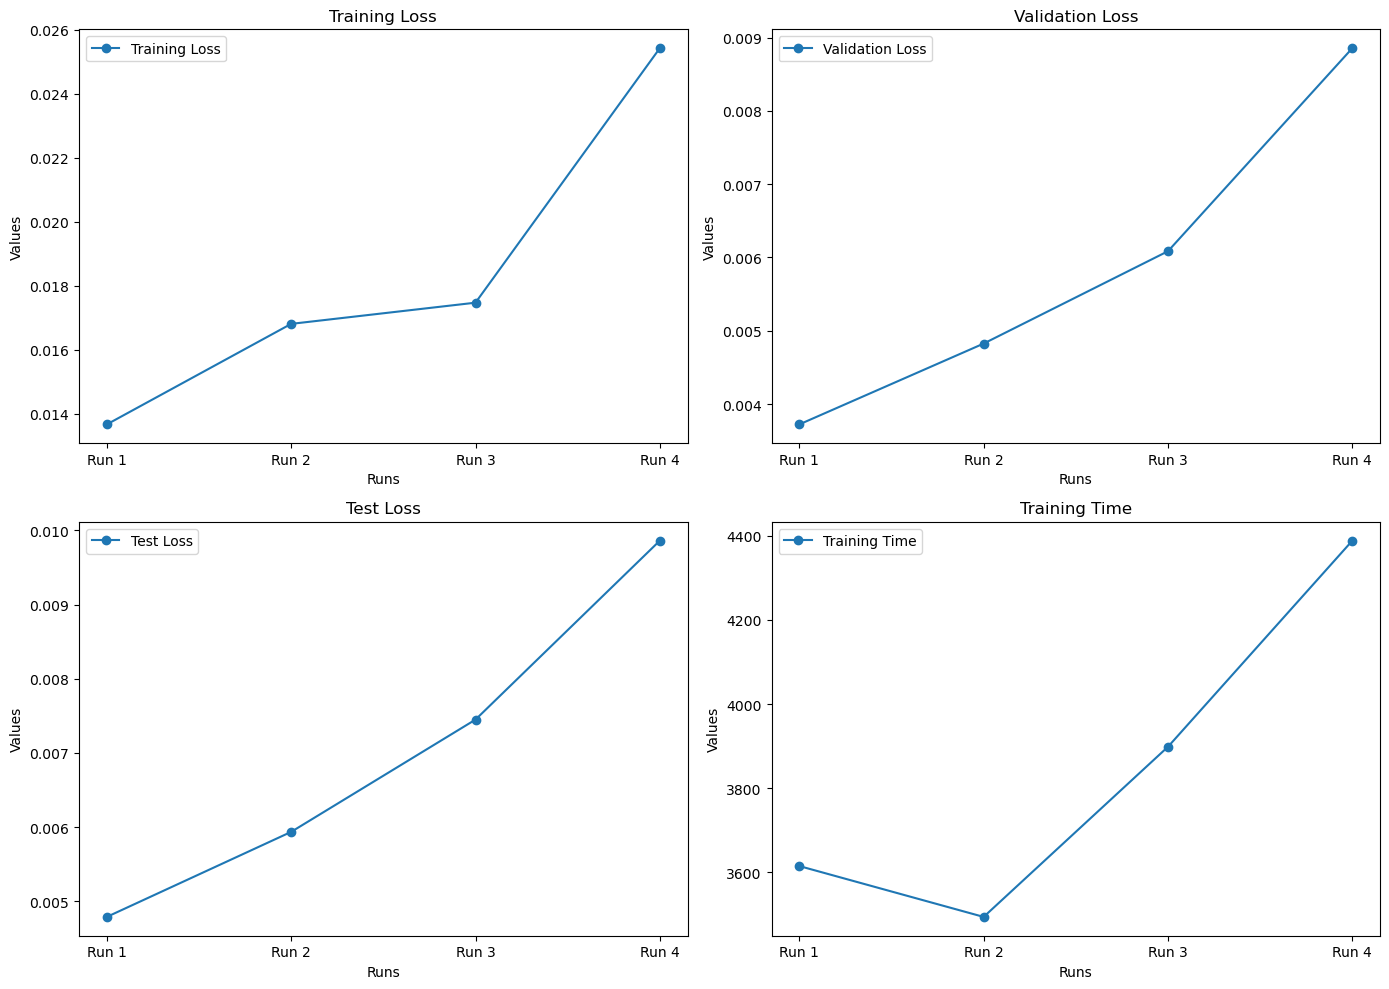

In [66]:
## uploading results for the same sequence length but several prediction regions
log_data = [
    {
        "epoch": 1,
        "train_loss": 0.0136619,
        "vali_loss": 0.0037231,
        "test_loss": 0.0047886,
        "loss_pred": 0.00786220448397294,
        "loss_entropy": 0.0028309395584325187,
        "loss_smooth": 0.0029687882786803167,
        "time": 3615.073413133621
    },
    {
        "epoch": 1,
        "train_loss": 0.0168049,
        "vali_loss": 0.0048258,
        "test_loss": 0.0059350,
        "loss_pred": 0.009989046275941741,
        "loss_entropy": 0.0032360439873068076,
        "loss_smooth": 0.003579777969087008,
        "time": 3494.2929928302765
    },
    {
        "epoch": 1,
        "train_loss": 0.0174674,
        "vali_loss": 0.0060858,
        "test_loss": 0.0074490,
        "loss_pred": 0.013131296017147276,
        "loss_entropy": 0.002265935485545761,
        "loss_smooth": 0.0020701771458536506,
        "time": 3898.435118198395
    },
    {
        "epoch": 1,
        "train_loss": 0.0254245,
        "vali_loss": 0.0088556,
        "test_loss": 0.0098619,
        "loss_pred": 0.020502921171709872,
        "loss_entropy": 0.002726393998175982,
        "loss_smooth": 0.002195145425148305,
        "time": 4388.012967824936
    }
]

## data rafe
df = pd.DataFrame(log_data)
df.index = [f'Run {i+1}' for i in range(len(log_data))]



plt.figure(figsize=(14, 10))

## training loss
plt.subplot(2, 2, 1)
plt.plot(df.index, df['train_loss'], marker='o', label='Training Loss')
plt.xlabel('Runs')
plt.ylabel('Values')
plt.title('Training Loss')
plt.legend()

## validation loss
plt.subplot(2, 2, 2)
plt.plot(df.index, df['vali_loss'], marker='o', label='Validation Loss')
plt.xlabel('Runs')
plt.ylabel('Values')
plt.title('Validation Loss')
plt.legend()

## test loss
plt.subplot(2, 2, 3)
plt.plot(df.index, df['test_loss'], marker='o', label='Test Loss')
plt.xlabel('Runs')
plt.ylabel('Values')
plt.title('Test Loss')
plt.legend()

## training time
plt.subplot(2, 2, 4)
plt.plot(df.index, df['time'], marker='o', label='Training Time')
plt.xlabel('Runs')
plt.ylabel('Values')
plt.title('Training Time')
plt.legend()

plt.tight_layout()
plt.show()

It can clearly be seen that as the prediction length increases, so too does the loss of prediction length, which is what we would expect.

# Conclusion and Improvement 
This study demonstrates the potential of transformer-based models, specifically Basisformer, in the context of multivariate energy time series forecasting. Through comprehensive preprocessing, careful model training, and thorough evaluation using various performance metrics, we achieve promising results that highlight the model's predictive capabilities. One can see that the model shows relatively small loss and can be considered effective for this type of data.

Nevertheless, there are several points where improvements could help enhance the model's performance even further. Exploring alternative methods for country encoding could reduce dimensionality, and this step of data preprocessing could be done beforehand, outside of the model. Additionally, implementing early stopping could be beneficial since the loss sometimes increased after a certain number of epochs. 

The next steps involve understanding how to save and plot prediction versus true values, as well as incorporating and displaying error metrics like MSE to better evaluate the model's accuracy.